# RNNによるfxデータ予測
!対数差分を取らずに予測
## 流れ
- データ読み込み
- データをtensorflow用(feature, target)に変換．depend: `delay`
- モデル構築，コンパイル．depend: `delay, n_hidden`
- 学習
- 学習評価, テスト評価

In [1]:
import tensorflow
from tensorflow.keras import  models, layers, callbacks, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sys
sys.path.append('../module')
from utils import load_fx_data, nrmse

np.random.seed(0)

# データ読み込み

In [2]:
instrument_list = ['USD_JPY', 'GBP_JPY', 'EUR_JPY']

df_dict_train = load_fx_data(instrument_list, data_kind='train')
df_dict_test = load_fx_data(instrument_list, data_kind='test')

df_dict_train['EUR_JPY']

,Open_ask,High_ask,Low_ask,Close_ask,Volume,Open_bid,High_bid,Low_bid,Close_bid
Time,,,,,,,,,
2014-01-01 22:00:00+00:00,144.926,145.163,142.859,143.366,143014,144.776,145.108,142.838,143.228
2014-01-02 22:00:00+00:00,143.387,143.387,141.975,142.527,113868,143.237,143.306,141.951,142.412
2014-01-05 22:00:00+00:00,142.515,142.793,141.512,142.080,125100,142.464,142.775,141.491,142.007
2014-01-06 22:00:00+00:00,142.080,142.600,141.951,142.449,115303,142.006,142.584,141.930,142.377
2014-01-07 22:00:00+00:00,142.449,143.184,142.130,142.405,128572,142.380,143.161,142.109,142.316
...,...,...,...,...,...,...,...,...,...
2018-12-03 22:00:00+00:00,129.037,129.065,127.632,127.951,26900,128.927,129.019,127.613,127.901
2018-12-04 22:00:00+00:00,127.989,128.502,127.801,128.439,16113,127.939,128.483,127.782,128.389
2018-12-05 22:00:00+00:00,128.433,128.468,127.683,128.214,37536,128.383,128.418,127.663,128.164


In [3]:
train = df_dict_train['USD_JPY']['Close_ask'].values[1:]
test = df_dict_test['USD_JPY']['Close_ask'].values[1:]
print(f'shape: {train.shape, test.shape}')

# 正規化
train = (train - train.mean())/train.std()
test  = (test - test.mean())/test.std()

shape: ((1297,), (274,))


In [18]:
# 参考までに現在の値を明日の予測値とする場合の誤差
rough_nrmse = nrmse(train[1:],train[:-1], 1)
print(f'rough forecast nrmse: {rough_nrmse}')

rough forecast nrmse: 0.09579552857347758


## RNN用feature, targetに変換

In [5]:
# RNN用feature, targetを生成 in: raw_data, delay out: feature, targets
def convert_data_for_RNN(raw_data, delay=25):
    """
    targetに対してdelay個の過去データをfeatureとする
    """
    features = np.array([raw_data[n:n+delay] for n in range(len(raw_data)-delay)]).reshape(-1, delay,1)
    targets = raw_data[delay:].reshape(-1,1,1)
    return features, targets

In [6]:
delay = 25
train_features, train_targets = convert_data_for_RNN(train, delay=delay)
test_features, test_targets = convert_data_for_RNN(test, delay=delay)

print(f'train: {train_features.shape, train_targets.shape}')
print(f'test: {test_features.shape, test_targets.shape}')

train: ((1272, 25, 1), (1272, 1, 1))
test: ((249, 25, 1), (249, 1, 1))


# モデル作成

In [7]:
train_std = train.std()
print(train_std)

1.0


In [8]:
# モデル構築
"""
n_hidden: 
dropout, recurrent_dropout
regulalizer
deep化
"""

print(f'delay: {delay}') # 時間遅れstep
out_size = 1 # targetのsize
n_hidden = 300 # 中間層のノード数

model = models.Sequential(name='RNN')
model.add(layers.SimpleRNN(n_hidden, input_shape=(delay, out_size), return_sequences=False, dropout=0., recurrent_dropout=0.,))
model.add(layers.Dense(out_size, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(learning_rate=1e-3))
model.summary()

delay: 25
Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 300)               90600     
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 90,901
Trainable params: 90,901
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 学習
callbacks.EarlyStopping()
model.fit(train_features,
          train_targets,
          batch_size=20,
          epochs=10,
          validation_split=0.2,
          callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')]
          )

Epoch 1/10
51/51 [==============================] - 1s 17ms/step - loss: 0.1721 - val_loss: 0.0100
Epoch 2/10
51/51 [==============================] - 0s 6ms/step - loss: 0.0266 - val_loss: 0.0083
Epoch 3/10
51/51 [==============================] - 0s 6ms/step - loss: 0.0186 - val_loss: 0.0078
Epoch 4/10
51/51 [==============================] - 0s 6ms/step - loss: 0.0146 - val_loss: 0.0060
Epoch 5/10
51/51 [==============================] - 0s 6ms/step - loss: 0.0138 - val_loss: 0.0059
Epoch 6/10
51/51 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0066
Epoch 7/10
51/51 [==============================] - 0s 5ms/step - loss: 0.0131 - val_loss: 0.0051
Epoch 8/10
51/51 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0054
Epoch 9/10
51/51 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0048
Epoch 10/10
51/51 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0047


40/40 [==============================] - 0s 2ms/step - loss: 0.0098
nrmse: 0.09909920996262363


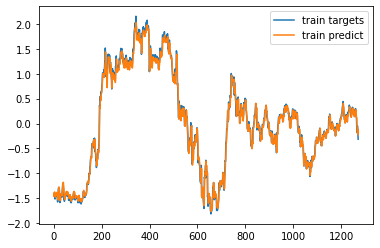

In [10]:
# fittingの確認
train_predict = model.predict(train_features)

start = 0
plt.plot(train_targets[start:, 0,0], label='train targets')
plt.plot(train_predict[start:], label='train predict')
plt.legend()

model.evaluate(train_features, train_targets)
train_nrmse = nrmse(train_targets, train_predict, train_std)
print(f'nrmse: {train_nrmse}')

8/8 [==============================] - 0s 3ms/step - loss: 0.0479
nrmse: 0.21894933072832543


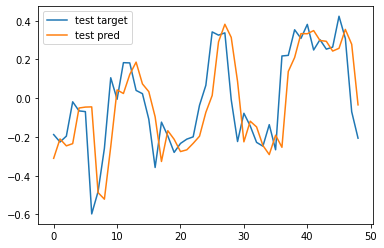

In [11]:
# 未来の予測
start = 200
test_predict = model.predict(test_features)

plt.plot(test_targets[start:,0,0], label='test target')
plt.plot(test_predict[start:], label='test pred')
plt.legend()

model.evaluate(test_features, test_targets)
test_nrmse = nrmse(test_targets, test_predict, 1)
print(f'nrmse: {test_nrmse}')

## 2021/01/10 観察
- 隠れ層のノード数は100以上にすると結果の振動が小さくなる?
- 評価方法はtrainのstdで正規化したrmseがいいかも

## 2021/01/17 観察
- 1step前の状態をそのまま予測値にしているのとほとんど変わらない．(25,30)

## パラメータを変えてみる
パラメータ
- `delay`: 時間遅れ
- `n_hidden`: 中間層ノード数
- dropout(オプション)
    - `dropout`
    - `recurrent_dropout`

条件
- パラメータ:
    - `delay`: `[10,25,50,100]`
    - `n_hidden`: `[5,10,25,50,100,200]`
- 学習:
    - `epoch=30`
    - `batch_size=20`
    - `learning_rate=1e-3`

In [12]:
delays = [10, 25, 50, 100, 200]
n_hiddens = [5, 10, 25, 50, 100, 200,300]

In [13]:
nrmse_results = np.zeros((len(delays), len(n_hiddens)))
for i, delay in enumerate(delays):
    print(f'delay: {delay}') # 時間遅れstep
    # 時間遅れ
    train_features, train_targets = convert_data_for_RNN(train, delay=delay)
    test_features, test_targets = convert_data_for_RNN(test, delay=delay)
    print(f'train: {train_features.shape, train_targets.shape}')
    print(f'test: {test_features.shape, test_targets.shape}')

    for j, n_hidden in enumerate(n_hiddens):
        print(f'n_hidden: {n_hidden}')
        # モデル構築
        model = models.Sequential(name='RNN')
        model.add(layers.SimpleRNN(n_hidden, input_shape=(delay, out_size), return_sequences=False, dropout=0., recurrent_dropout=0.,))
        model.add(layers.Dense(out_size, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(learning_rate=1e-3))
        # model.summary()

        # 学習
        callbacks.EarlyStopping()
        model.fit(train_features,
                train_targets,
                batch_size=20,
                epochs=30,
                validation_split=0.2,
                callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                verbose=0
                )
        
        train_predict = model.predict(train_features)

        train_nrmse = nrmse(train_targets, train_predict, train_std)
        print(f'nrmse: {train_nrmse}')
        nrmse_results[i,j] = train_nrmse

        print('---------------------')
    print('=========================')

delay: 10
train: ((1287, 10, 1), (1287, 1, 1))
test: ((264, 10, 1), (264, 1, 1))
n_hidden: 5
nrmse: 0.11351975833342093
---------------------
n_hidden: 10
nrmse: 0.10044443436542863
---------------------
n_hidden: 25
nrmse: 0.10263221851764728
---------------------
n_hidden: 50
nrmse: 0.10629107094303311
---------------------
n_hidden: 100
nrmse: 0.10248607597892209
---------------------
n_hidden: 200
nrmse: 0.09599270754131381
---------------------
n_hidden: 300
nrmse: 0.09656197026240489
---------------------
delay: 25
train: ((1272, 25, 1), (1272, 1, 1))
test: ((249, 25, 1), (249, 1, 1))
n_hidden: 5
nrmse: 0.11751158506095037
---------------------
n_hidden: 10
nrmse: 0.09855530195943615
---------------------
n_hidden: 25
nrmse: 0.10656566158205225
---------------------
n_hidden: 50
nrmse: 0.09376419207362165
---------------------
n_hidden: 100
nrmse: 0.09578853439398857
---------------------
n_hidden: 200
nrmse: 0.10119330022390992
---------------------
n_hidden: 300
nrmse: 0.095020

In [15]:
df = pd.DataFrame(nrmse_results, index=delays, columns=n_hiddens)
# df.to_csv('../data/csv/delay_nhidden_nrmse.csv')

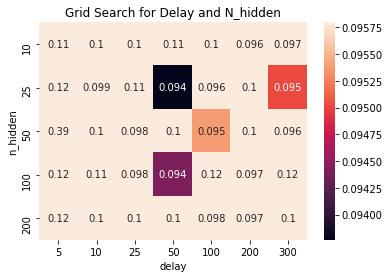

In [20]:
fig = plt.figure()
sns.heatmap(df, annot=True, vmax=rough_nrmse)
plt.title('Grid Search for Delay and N_hidden')
plt.xlabel('delay')
plt.ylabel('n_hidden')
fig.savefig('../data/img/delay_nhidden_nrmse.png')